In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats

In [2]:
df = pd.read_excel('DJIA Realized Volatility.xlsx',index_col='Date',parse_dates=True)


Text(0, 0.5, 'Realized Volatility')

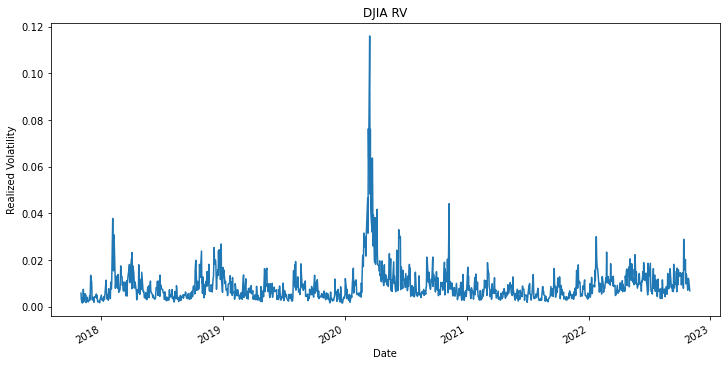

In [4]:
df["Realised"].plot(figsize=(12,6))
plt.title("DJIA RV")
plt.xlabel("Date")
plt.ylabel("Realized Volatility")

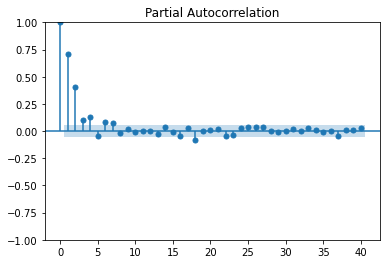

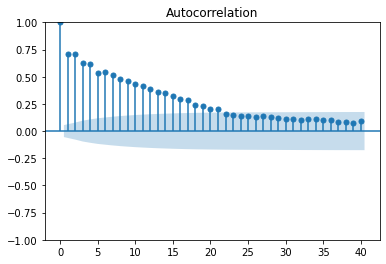

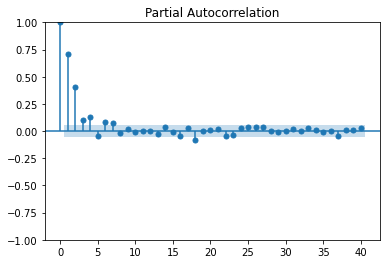

In [5]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(df["Realised"], lags = 40) 
plot_pacf(df["Realised"], lags = 40, method = "ols")

Augmented Dickey Fuller test

In [6]:
from statsmodels.tsa.stattools import adfuller
adfuller(df["Realised"])

(-5.627140918448834,
 1.1107241076192678e-06,
 6,
 1250,
 {'1%': -3.435592223709696, '5%': -2.8638549702604803, '10%': -2.56800251776},
 -9636.424328599536)

In [7]:
len(df["Realised"])


1257

Breusch Godfrey test

In [8]:
df_for_Breusch_Godfrey_test = df.reset_index(drop=True)

In [9]:
import statsmodels.api as sm
y = df_for_Breusch_Godfrey_test["Realised"]
x = df_for_Breusch_Godfrey_test[['Realised']][:1256]

In [10]:
for i in range(len(y)-1):
    y[i]=y[i+1]

C:\Users\GobatoH\AppData\Local\Temp\ipykernel_10908\3328281496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[i]=y[i+1]


In [11]:
y=y[:1256]

In [12]:
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()

In [13]:
import statsmodels.stats.diagnostic as dg

In [14]:
print(dg.acorr_breusch_godfrey(model, nlags=10))

(251.66271362606386, 2.4265825646591704e-48, 31.160016225765855, 4.341606995942436e-54)


Ljung-Box Test

In [15]:
def sac(x, k=1):
    """
    Sample autocorrelation (As used in statistics with normalization)
    http://en.wikipedia.org/wiki/Autocorrelation
    Parameters
    ----------
    x : 1d numpy array
        Signal
    k : int or list of ints
        Lags to calculate sample autocorrelation for
    Returns
    -------
    res : scalar or np array
        The sample autocorrelation. A scalar value if k is a scalar, and a
        numpy array if k is a interable.
    """
    try:
        res = []
        for ki in k:
            res.append(sac(x, ki))
        return np.array(res)
    except:
        pass
    mx = np.mean(x)
    if k==0:
        N = np.sum((x-mx)*(x-mx))
    else:
        N = np.sum((x[:-k]-mx)*(x[k:]-mx))
    D = len(x) * np.var(x)
    return N/D


def ljungbox(x, lags, alpha=0.1):
    """
    The Ljung-Box test for determining if the data is independently distributed.
    Parameters
    ----------
    x : 1d numpy array
        Signal to test
    lags : int
        Number of lags being tested
       
    Returns
    -------
    Q : float
        Test statistic
    """
    n = len(x)
    Q = 0
    for k in range(1, lags+1):
        Q += (sac(x, k)**2) / (n-k)
    Q = n*(n+2)*Q
    return Q

def boxpierce(x, lags, alpha=0.1):
    """
    The Box-Pierce test for determining if the data is independently distributed.
    Parameters
    ----------
    x : 1d numpy array
        Signal to test
    lags : int
        Number of lags being tested
       
    Returns
    -------
    Q : float
        Test statistic
    """
    n = len(x)
    Q = 0
    for k in range(1, lags+1):
        Q += (sac(x, k)**2)
    Q = n*Q
    return Q

def lbqtest(x, lags, alpha=0.1, method='lb'):
    """
    The Ljung-Box test for determining if the data is independently distributed.
    Parameters
    ----------
    x : 1d numpy array
        Signal to test
    lags : list of ints
        Lags being tested
    alpha : float
        Significance level used for the tests
    method : string
        Can be either 'lb' for Ljung-Box, or 'bp' for Box-Pierce
       
    Returns
    -------
    h : np array
        Numpy array of bool values, True == H0 hypothesis rejected
    pV : np array
        Test statistics p-values
    Q : np array
        Test statistics
    cV : np array
        Critical values used for determining if H0 should be rejected. The
        critical values are calculated from the given alpha and lag.
    """
    if method=='lb':
        findq = ljungbox
    else:
        findq = boxpierce
    n = len(x)
    Q = np.zeros(len(lags))
    pV = np.zeros(len(lags))
    cV = np.zeros(len(lags))
    for i, lag in enumerate(lags):
        Q[i] = findq(x, lag)
        pV[i] = 1.0 - scipy.stats.chi2.cdf(Q[i], lag)
        cV[i] = scipy.stats.chi2.ppf(1-alpha, lag)
    h = Q>cV
    return h, pV, Q, cV

In [16]:
h, pV, Q, cV = lbqtest(y, range(1, 20), alpha=0.1)
print ('lag   p-value          Q    c-value   rejectH0')
for i in range(len(h)):
    print ("%-2d %10.3f %10.3f %10.3f      %s" % (i+1, pV[i], Q[i], cV[i], str(h[i])))

lag   p-value          Q    c-value   rejectH0
1       0.000   1257.626      2.706      True
2       0.000   2514.183      4.605      True
3       0.000   3770.444      6.251      True
4       0.000   5025.810      7.779      True
5       0.000   6281.994      9.236      True
6       0.000   7537.591     10.645      True
7       0.000   8792.381     12.017      True
8       0.000  10046.897     13.362      True
9       0.000  11301.606     14.684      True
10      0.000  12552.354     15.987      True
11      0.000  13800.725     17.275      True
12      0.000  15046.779     18.549      True
13      0.000  16279.229     19.812      True
14      0.000  17511.136     21.064      True
15      0.000  18741.310     22.307      True
16      0.000  19971.084     23.542      True
17      0.000  21200.612     24.769      True
18      0.000  22429.875     25.989      True
19      0.000  23659.045     27.204      True


In [17]:
from pandas.plotting import lag_plot

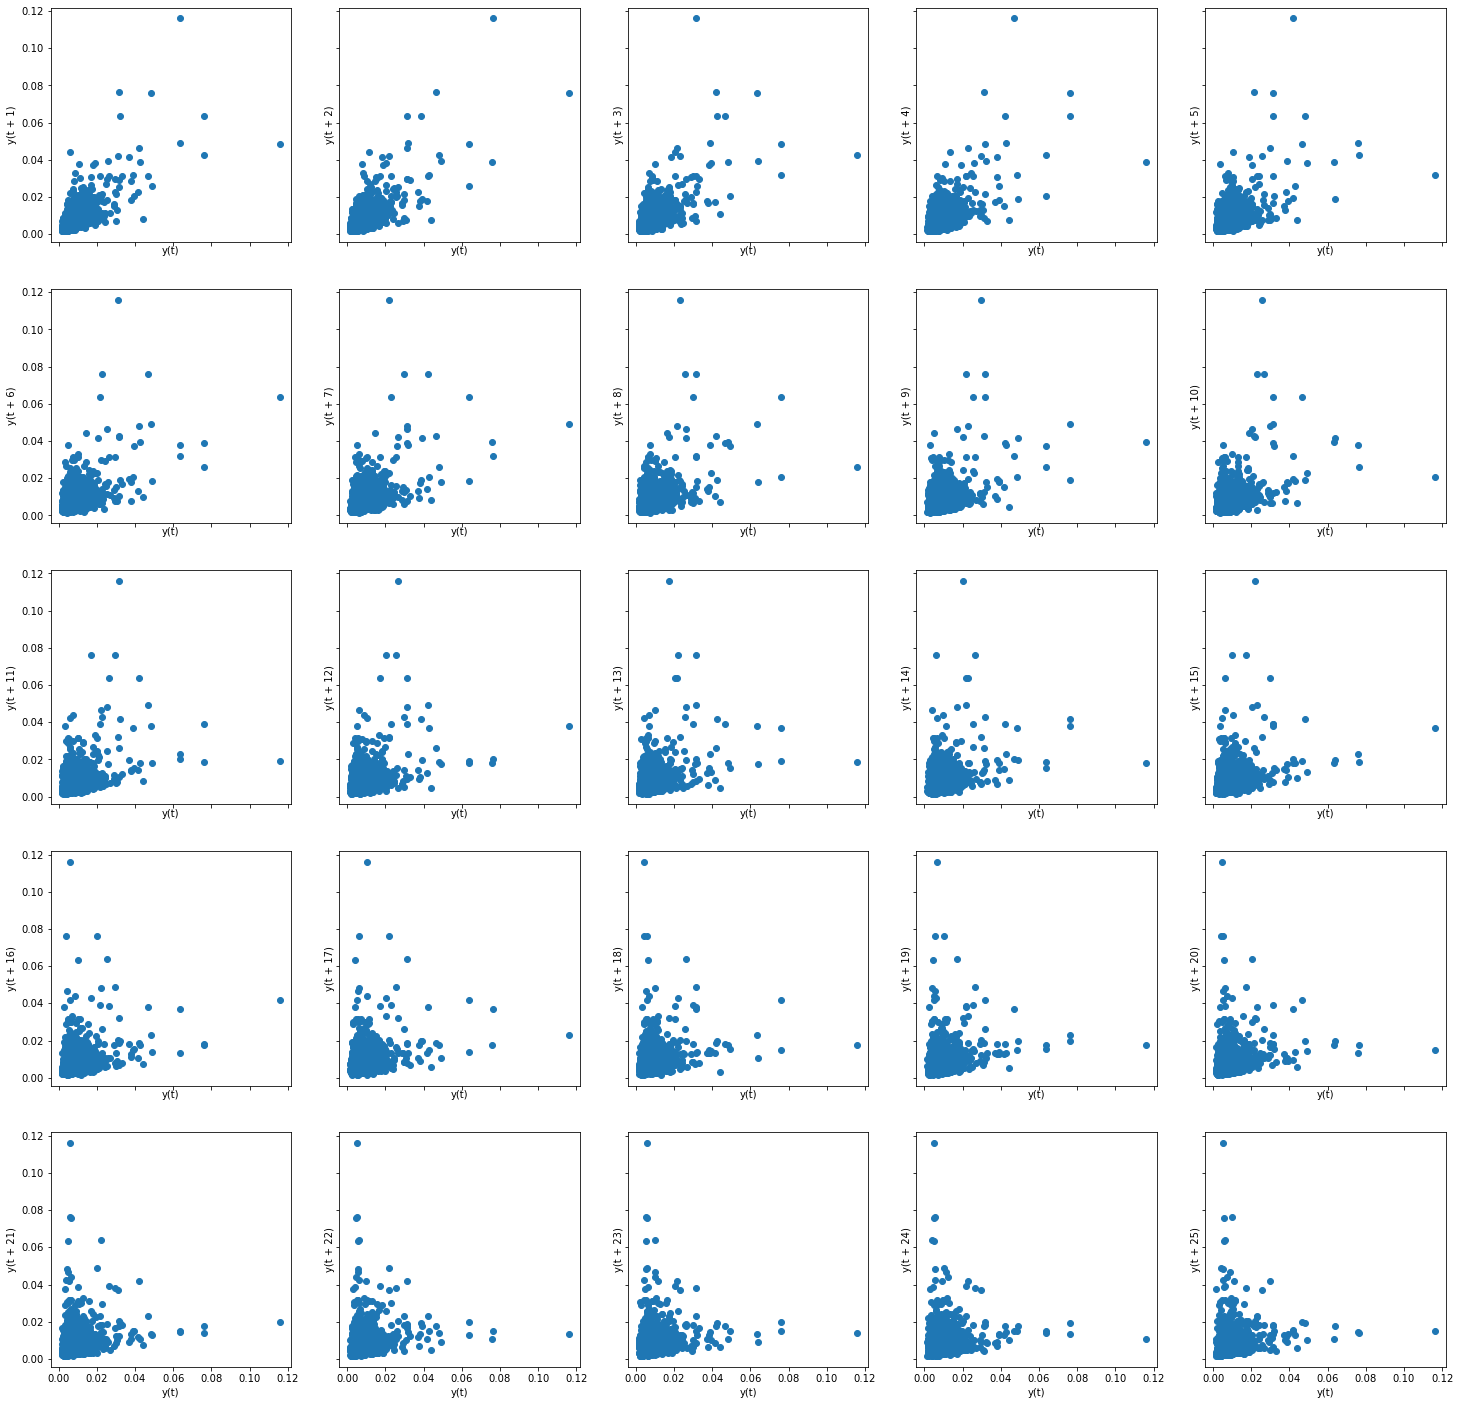

In [18]:
plot_lags = 25
rows = int(plot_lags/5)
cols = int(plot_lags/5)
fig, axes = plt.subplots(rows, cols, sharex=True, sharey=True)
fig.set_figwidth(plot_lags)
fig.set_figheight(plot_lags)
count =1
for i in range(rows):
    for j in range(cols):
        lag_plot(df["Realised"], lag=count, ax=axes[i, j])
        count+=1

Model Inputs Selection

In [5]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

In [6]:
n_inputs = [21,63,84,126,189,252]
n_neurons = [14,42,56,84,126,168]
RMSE = []
Accuracy = []
scaler = MinMaxScaler()

Determining the number of inputs

First trial (5 epochs)

In [21]:
for m in range (1):
    for i in range (6):
        train = df.iloc[:905]
        validation = df.iloc[905:1005]
        test = df.iloc[1005:]
        scaler.fit(train)
        scaled_train_input = scaler.transform(train)
        scaled_validation_input = scaler.transform(validation)
        scaled_test_input = scaler.transform(test)
        train = df["Realised"].iloc[:905]
        validation = df["Realised"].iloc[905:1005]
        test = df["Realised"].iloc[1005:]
        train = train.array.reshape(-1, 1)
        validation = validation.array.reshape(-1, 1)
        test = test.array.reshape(-1, 1)
        scaler.fit(train)
        scaled_train_target = scaler.transform(train)
        scaled_validation_target = scaler.transform(validation)
        scaled_test_target = scaler.transform(test)
        n_features = 4
        n_input = n_inputs[i]
        generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=1)
        model = Sequential()
        model.add(LSTM(n_neurons[i], activation='relu', input_shape=(n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator,epochs=5)
        last_train_batch = scaled_train_input[-n_input:]
        last_train_batch = last_train_batch.reshape((1, n_input, n_features))
        a = np.array(scaled_validation_input)
        test_predictions = []
        first_eval_batch = scaled_train_input[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
        for j in range(len(scaled_validation_input)):
            # get the prediction value for the first batch
            current_pred = model.predict(current_batch)[0]
            # append the prediction into the array
            test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
            current_batch = np.append(current_batch[:,1:,:],[[a[j]]],axis=1)
        true_predictions = scaler.inverse_transform(test_predictions)
        RMSE.append(np.sum(np.sqrt((validation-true_predictions)**2))/len(validation))
        Accuracy.append((1-(np.sum(np.sqrt((validation-true_predictions)**2)/validation)/len(validation)))*100)

Epoch 1/5
884/884 [==============================] - 8s 7ms/step - loss: 0.0037
Epoch 2/5
884/884 [==============================] - 5s 6ms/step - loss: 0.0029
Epoch 3/5
884/884 [==============================] - 5s 6ms/step - loss: 0.0027
Epoch 4/5
884/884 [==============================] - 6s 7ms/step - loss: 0.0026
Epoch 5/5
1/1 [==============================] - 0s 19ms/step
Epoch 1/5
842/842 [==============================] - 19s 20ms/step - loss: 0.0036
Epoch 2/5
842/842 [==============================] - 15s 17ms/step - loss: 0.0028
Epoch 3/5
842/842 [==============================] - 14s 16ms/step - loss: 0.0028
Epoch 4/5
842/842 [==============================] - 15s 18ms/step - loss: 0.0026
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 28ms/step
Epoch 1/5
821/821 [==============================] - 21s 22ms/step - loss: 194.5225
Epoch 2/5
821/821 [==============================] - 18s 22ms/step - loss: 0.0033
Epoch 3/5
821/821 [==============================] - 21s 25ms/step - loss: 0.0028
Epoch 4/5
821/821 [==============================] - 18s 22ms/step - loss: 0.0026
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step
Epoch 1/5
779/779 [==============================] - 28s 34ms/step - loss: 0.0035
Epoch 2/5
779/779 [==============================] - 27s 34ms/step - loss: 0.0030
Epoch 3/5
779/779 [==============================] - 26s 33ms/step - loss: nan
Epoch 4/5
779/779 [==============================] - 31s 39ms/step - loss: nan
Epoch 5/5
1/1 [==============================] - 0s 34ms/step
Epoch 1/5
716/716 [==============================] - 48s 65ms/step - loss: 0.0035
Epoch 2/5
716/716 [==============================] - 41s 58ms/step - loss: nan
Epoch 3/5
716/716 [==============================] - 52s 72ms/step - loss: nan
Epoch 4/5
716/716 [==============================] - 41s 57ms/step - loss: nan
Epoch 5/5
1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 31ms/step
Epoch 1/5
653/653 [==============================] - 54s 81ms/step - loss: 0.0139
Epoch 2/5
653/653 [==============================] - 53s 81ms/step - loss: 0.0033
Epoch 3/5
653/653 [==============================] - 55s 83ms/step - loss: 0.0030
Epoch 4/5
653/653 [==============================] - 59s 91ms/step - loss: 0.0027
Epoch 5/5
1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 43ms/step


In [22]:
RMSE

[0.0018966624282244996,
 0.0020251783470538382,
 0.002086887575598244,
 0.0,
 0.0,
 0.0]

In [23]:
Accuracy

[59.02460263542044, 52.979074927409876, 51.6027614493608, 100.0, 100.0, 100.0]

Second trial (10 epochs)

In [24]:
RMSE = []
Accuracy = []
for m in range (1):
    for i in range (6):
        train = df.iloc[:905]
        validation = df.iloc[905:1005]
        test = df.iloc[1005:]
        scaler.fit(train)
        scaled_train_input = scaler.transform(train)
        scaled_validation_input = scaler.transform(validation)
        scaled_test_input = scaler.transform(test)
        train = df["Realised"].iloc[:905]
        validation = df["Realised"].iloc[905:1005]
        test = df["Realised"].iloc[1005:]
        train = train.array.reshape(-1, 1)
        validation = validation.array.reshape(-1, 1)
        test = test.array.reshape(-1, 1)
        scaler.fit(train)
        scaled_train_target = scaler.transform(train)
        scaled_validation_target = scaler.transform(validation)
        scaled_test_target = scaler.transform(test)
        n_features = 4
        n_input = n_inputs[i]
        generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=1)
        model = Sequential()
        model.add(LSTM(n_neurons[i], activation='relu', input_shape=(n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator,epochs=10)
        last_train_batch = scaled_train_input[-n_input:]
        last_train_batch = last_train_batch.reshape((1, n_input, n_features))
        a = np.array(scaled_validation_input)
        test_predictions = []
        first_eval_batch = scaled_train_input[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
        for j in range(len(scaled_validation_input)):
            # get the prediction value for the first batch
            current_pred = model.predict(current_batch)[0]
            # append the prediction into the array
            test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
            current_batch = np.append(current_batch[:,1:,:],[[a[j]]],axis=1)
        true_predictions = scaler.inverse_transform(test_predictions)
        RMSE.append(np.sum(np.sqrt((validation-true_predictions)**2))/len(validation))
        Accuracy.append((1-(np.sum(np.sqrt((validation-true_predictions)**2)/validation)/len(validation)))*100)

Epoch 1/10
884/884 [==============================] - 7s 5ms/step - loss: 0.0039
Epoch 2/10
884/884 [==============================] - 5s 5ms/step - loss: 0.0029
Epoch 3/10
884/884 [==============================] - 5s 5ms/step - loss: 0.0026
Epoch 4/10
884/884 [==============================] - 5s 5ms/step - loss: 0.0026
Epoch 5/10
884/884 [==============================] - 5s 6ms/step - loss: 0.0024
Epoch 6/10
884/884 [==============================] - 6s 6ms/step - loss: 0.0025
Epoch 7/10
884/884 [==============================] - 6s 7ms/step - loss: 0.0023
Epoch 8/10
884/884 [==============================] - 6s 7ms/step - loss: 0.0023
Epoch 9/10
884/884 [==============================] - 5s 6ms/step - loss: 0.0023
Epoch 10/10
1/1 [==============================] - 0s 26ms/step
Epoch 1/10
842/842 [==============================] - 15s 16ms/step - loss: 0.0036
Epoch 2/10
842/842 [==============================] - 15s 18ms/step - loss: 0.0030
Epoch 3/10
842/842 [=====================

1/1 [==============================] - 0s 22ms/step
Epoch 1/10
821/821 [==============================] - 17s 19ms/step - loss: 0.0034
Epoch 2/10
821/821 [==============================] - 17s 21ms/step - loss: 0.0027
Epoch 3/10
821/821 [==============================] - 17s 21ms/step - loss: 0.0027
Epoch 4/10
821/821 [==============================] - 17s 21ms/step - loss: 0.0025
Epoch 5/10
821/821 [==============================] - 17s 20ms/step - loss: 0.0024
Epoch 6/10
821/821 [==============================] - 17s 21ms/step - loss: 0.0023
Epoch 7/10
821/821 [==============================] - 17s 20ms/step - loss: 0.0024
Epoch 8/10
821/821 [==============================] - 17s 21ms/step - loss: 0.0022
Epoch 9/10
821/821 [==============================] - 17s 20ms/step - loss: 0.0022
Epoch 10/10
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step
Epoch 1/10
779/779 [==============================] - 27s 32ms/step - loss: 0.0034
Epoch 2/10
779/779 [==============================] - 31s 40ms/step - loss: 0.0028
Epoch 3/10
779/779 [==============================] - 35s 45ms/step - loss: 0.0027
Epoch 4/10
779/779 [==============================] - 39s 50ms/step - loss: 0.0025
Epoch 5/10
779/779 [==============================] - 25s 32ms/step - loss: 0.0026
Epoch 6/10
779/779 [==============================] - 28s 36ms/step - loss: 0.0024
Epoch 7/10
779/779 [==============================] - 26s 34ms/step - loss: 0.0025
Epoch 8/10
779/779 [==============================] - 29s 37ms/step - loss: 0.0025
Epoch 9/10
779/779 [==============================] - 34s 43ms/step - loss: 0.0025
Epoch 10/10
1/1 [==============================] - 0s 34ms/step
Epoch 1/10
716/716 [==============================] - 47s 62ms/step - loss: 0.0036
Epoch 2/10
716/716 [==============================] - 

716/716 [==============================] - 48s 66ms/step - loss: 0.0025
Epoch 7/10
716/716 [==============================] - 46s 65ms/step - loss: 0.0026
Epoch 8/10
716/716 [==============================] - 47s 66ms/step - loss: 0.0026
Epoch 9/10
716/716 [==============================] - 54s 76ms/step - loss: 0.0025
Epoch 10/10
1/1 [==============================] - 0s 35ms/step
Epoch 1/10
653/653 [==============================] - 64s 94ms/step - loss: 0.0041
Epoch 2/10
653/653 [==============================] - 62s 95ms/step - loss: nan
Epoch 3/10
653/653 [==============================] - 61s 93ms/step - loss: nan
Epoch 4/10
653/653 [==============================] - 60s 92ms/step - loss: nan
Epoch 5/10
653/653 [==============================] - 51s 78ms/step - loss: nan
Epoch 6/10
653/653 [==============================] - 51s 78ms/step - loss: nan
Epoch 7/10
653/653 [==============================] - 51s 78ms/step - loss: nan
Epoch 8/10
653/653 [==============================] 

1/1 [==============================] - 0s 45ms/step


In [25]:
RMSE

[0.002267152535027938,
 0.0025452328971374417,
 0.0020202918141694107,
 0.002092402076098497,
 0.0018662169018852429,
 0.0]

In [26]:
Accuracy

[45.281537359612315,
 36.82086505362153,
 52.59382425086938,
 50.27190997086854,
 60.81190276936992,
 100.0]

Third trial (15 epochs)

In [27]:
RMSE = []
Accuracy = []
for m in range (1):
    for i in range (6):
        train = df.iloc[:905]
        validation = df.iloc[905:1005]
        test = df.iloc[1005:]
        scaler.fit(train)
        scaled_train_input = scaler.transform(train)
        scaled_validation_input = scaler.transform(validation)
        scaled_test_input = scaler.transform(test)
        train = df["Realised"].iloc[:905]
        validation = df["Realised"].iloc[905:1005]
        test = df["Realised"].iloc[1005:]
        train = train.array.reshape(-1, 1)
        validation = validation.array.reshape(-1, 1)
        test = test.array.reshape(-1, 1)
        scaler.fit(train)
        scaled_train_target = scaler.transform(train)
        scaled_validation_target = scaler.transform(validation)
        scaled_test_target = scaler.transform(test)
        n_features = 4
        n_input = n_inputs[i]
        generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=1)
        model = Sequential()
        model.add(LSTM(n_neurons[i], activation='relu', input_shape=(n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator,epochs=15)
        last_train_batch = scaled_train_input[-n_input:]
        last_train_batch = last_train_batch.reshape((1, n_input, n_features))
        a = np.array(scaled_validation_input)
        test_predictions = []
        first_eval_batch = scaled_train_input[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
        for j in range(len(scaled_validation_input)):
            # get the prediction value for the first batch
            current_pred = model.predict(current_batch)[0]
            # append the prediction into the array
            test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
            current_batch = np.append(current_batch[:,1:,:],[[a[j]]],axis=1)
        true_predictions = scaler.inverse_transform(test_predictions)
        RMSE.append(np.sum(np.sqrt((validation-true_predictions)**2))/len(validation))
        Accuracy.append((1-(np.sum(np.sqrt((validation-true_predictions)**2)/validation)/len(validation)))*100)

Epoch 1/15
884/884 [==============================] - 11s 9ms/step - loss: 0.0038
Epoch 2/15
884/884 [==============================] - 8s 10ms/step - loss: 0.0029
Epoch 3/15
884/884 [==============================] - 8s 9ms/step - loss: 0.0028
Epoch 4/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0026
Epoch 5/15
884/884 [==============================] - 8s 9ms/step - loss: 0.0026
Epoch 6/15
884/884 [==============================] - 8s 9ms/step - loss: 0.0025
Epoch 7/15
884/884 [==============================] - 9s 10ms/step - loss: 0.0024
Epoch 8/15
884/884 [==============================] - 8s 9ms/step - loss: 0.0024
Epoch 9/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0023
Epoch 10/15
884/884 [==============================] - 9s 10ms/step - loss: 0.0023
Epoch 11/15
884/884 [==============================] - 9s 10ms/step - loss: 0.0021
Epoch 12/15
884/884 [==============================] - 8s 9ms/step - loss: 0.0023
Epoch 13/15
884/884 

1/1 [==============================] - 0s 21ms/step
Epoch 1/15
821/821 [==============================] - 17s 19ms/step - loss: 0.0034
Epoch 2/15
821/821 [==============================] - 16s 19ms/step - loss: 0.0025
Epoch 3/15
821/821 [==============================] - 17s 20ms/step - loss: 0.0027
Epoch 4/15
821/821 [==============================] - 16s 20ms/step - loss: 0.0024
Epoch 5/15
821/821 [==============================] - 16s 19ms/step - loss: 0.0023
Epoch 6/15
821/821 [==============================] - 16s 19ms/step - loss: 0.0025
Epoch 7/15
821/821 [==============================] - 16s 20ms/step - loss: 0.0022
Epoch 8/15
821/821 [==============================] - 16s 19ms/step - loss: 0.0023
Epoch 9/15
821/821 [==============================] - 16s 19ms/step - loss: 0.0022
Epoch 10/15
821/821 [==============================] - 16s 20ms/step - loss: 0.0021
Epoch 11/15
821/821 [==============================] - 16s 19ms/step - loss: 0.0022
Epoch 12/15
821/821 [============

1/1 [==============================] - 0s 46ms/step
Epoch 1/15
779/779 [==============================] - 34s 40ms/step - loss: 0.0035
Epoch 2/15
779/779 [==============================] - 30s 38ms/step - loss: 0.0029
Epoch 3/15
779/779 [==============================] - 28s 36ms/step - loss: 0.0026
Epoch 4/15
779/779 [==============================] - 33s 43ms/step - loss: 0.0028
Epoch 5/15
779/779 [==============================] - 26s 33ms/step - loss: 0.0023
Epoch 6/15
779/779 [==============================] - 24s 31ms/step - loss: 0.0026
Epoch 7/15
779/779 [==============================] - 25s 32ms/step - loss: 0.0022
Epoch 8/15
779/779 [==============================] - 24s 31ms/step - loss: 0.0022
Epoch 9/15
779/779 [==============================] - 31s 39ms/step - loss: 0.0023
Epoch 10/15
779/779 [==============================] - 38s 48ms/step - loss: 0.0021
Epoch 11/15
779/779 [==============================] - 27s 35ms/step - loss: 0.0025
Epoch 12/15
779/779 [============

1/1 [==============================] - 0s 27ms/step
Epoch 1/15
716/716 [==============================] - 38s 51ms/step - loss: 0.0037
Epoch 2/15
716/716 [==============================] - 36s 51ms/step - loss: 0.0031
Epoch 3/15
716/716 [==============================] - 37s 51ms/step - loss: 0.0028
Epoch 4/15
716/716 [==============================] - 41s 57ms/step - loss: 0.0028
Epoch 5/15
716/716 [==============================] - 43s 60ms/step - loss: 0.0026
Epoch 6/15
716/716 [==============================] - 39s 54ms/step - loss: 0.0028
Epoch 7/15
716/716 [==============================] - 44s 62ms/step - loss: 0.0024
Epoch 8/15
716/716 [==============================] - 40s 56ms/step - loss: 0.0025
Epoch 9/15
716/716 [==============================] - 39s 54ms/step - loss: 0.0022
Epoch 10/15
716/716 [==============================] - 39s 54ms/step - loss: 0.0027
Epoch 11/15
716/716 [==============================] - 45s 63ms/step - loss: 0.0025
Epoch 12/15
716/716 [============

653/653 [==============================] - 51s 78ms/step - loss: nan
Epoch 7/15
653/653 [==============================] - 51s 78ms/step - loss: nan
Epoch 8/15
653/653 [==============================] - 53s 81ms/step - loss: nan
Epoch 9/15
653/653 [==============================] - 52s 79ms/step - loss: nan
Epoch 10/15
653/653 [==============================] - 52s 79ms/step - loss: nan
Epoch 11/15
307/653 [=============>................] - ETA: 28s - loss: nan

KeyboardInterrupt: 

In [28]:
RMSE

[0.0018873027468528348,
 0.0017748813830737393,
 0.0018321204083269268,
 0.0019710473825884285,
 0.0022906979270819728]

In [29]:
Accuracy

[59.666213346749885,
 62.58543252483897,
 61.13661719872938,
 54.26005390740585,
 43.573893976176194]

15 epochs were chosen

Fourth trial

In [5]:
RMSE = []
Accuracy = []
for m in range (1):
    for i in range (6):
        train = df.iloc[:905]
        validation = df.iloc[905:1005]
        test = df.iloc[1005:]
        scaler.fit(train)
        scaled_train_input = scaler.transform(train)
        scaled_validation_input = scaler.transform(validation)
        scaled_test_input = scaler.transform(test)
        train = df["Realised"].iloc[:905]
        validation = df["Realised"].iloc[905:1005]
        test = df["Realised"].iloc[1005:]
        train = train.array.reshape(-1, 1)
        validation = validation.array.reshape(-1, 1)
        test = test.array.reshape(-1, 1)
        scaler.fit(train)
        scaled_train_target = scaler.transform(train)
        scaled_validation_target = scaler.transform(validation)
        scaled_test_target = scaler.transform(test)
        n_features = 4
        n_input = n_inputs[i]
        generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=1)
        model = Sequential()
        model.add(LSTM(n_neurons[i], activation='relu', input_shape=(n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator,epochs=15)
        last_train_batch = scaled_train_input[-n_input:]
        last_train_batch = last_train_batch.reshape((1, n_input, n_features))
        a = np.array(scaled_validation_input)
        test_predictions = []
        first_eval_batch = scaled_train_input[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
        for j in range(len(scaled_validation_input)):
            # get the prediction value for the first batch
            current_pred = model.predict(current_batch)[0]
            # append the prediction into the array
            test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
            current_batch = np.append(current_batch[:,1:,:],[[a[j]]],axis=1)
        true_predictions = scaler.inverse_transform(test_predictions)
        RMSE.append(np.sum(np.sqrt((validation-true_predictions)**2))/len(validation))
        Accuracy.append((1-(np.sum(np.sqrt((validation-true_predictions)**2)/validation)/len(validation)))*100)

Epoch 1/15
884/884 [==============================] - 8s 7ms/step - loss: 0.0032
Epoch 2/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0028
Epoch 3/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0027
Epoch 4/15
884/884 [==============================] - 6s 7ms/step - loss: 0.0025
Epoch 5/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0024
Epoch 6/15
884/884 [==============================] - 5s 6ms/step - loss: 0.0024
Epoch 7/15
884/884 [==============================] - 6s 7ms/step - loss: 0.0024
Epoch 8/15
884/884 [==============================] - 6s 7ms/step - loss: 0.0022
Epoch 9/15
884/884 [==============================] - 6s 7ms/step - loss: 0.0024
Epoch 10/15
884/884 [==============================] - 8s 9ms/step - loss: 0.0023
Epoch 11/15
884/884 [==============================] - 6s 7ms/step - loss: 0.0023
Epoch 12/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0023
Epoch 13/15
884/884 [====

1/1 [==============================] - 0s 25ms/step
Epoch 1/15
821/821 [==============================] - 26s 28ms/step - loss: 0.0033
Epoch 2/15
821/821 [==============================] - 22s 26ms/step - loss: 0.0027
Epoch 3/15
821/821 [==============================] - 22s 27ms/step - loss: 0.0024
Epoch 4/15
821/821 [==============================] - 18s 21ms/step - loss: 0.0026
Epoch 5/15
821/821 [==============================] - 19s 23ms/step - loss: 0.0022
Epoch 6/15
821/821 [==============================] - 23s 28ms/step - loss: 11191.6338
Epoch 7/15
821/821 [==============================] - 23s 28ms/step - loss: 0.0025
Epoch 8/15
821/821 [==============================] - 21s 26ms/step - loss: 0.0024
Epoch 9/15
821/821 [==============================] - 23s 28ms/step - loss: 0.0024
Epoch 10/15
821/821 [==============================] - 23s 27ms/step - loss: 0.0022
Epoch 11/15
821/821 [==============================] - 19s 23ms/step - loss: 0.0022
Epoch 12/15
821/821 [========

1/1 [==============================] - 0s 34ms/step
Epoch 1/15
779/779 [==============================] - 31s 36ms/step - loss: 0.0030
Epoch 2/15
779/779 [==============================] - 36s 46ms/step - loss: 0.0027
Epoch 3/15
779/779 [==============================] - 37s 47ms/step - loss: 0.0026
Epoch 4/15
779/779 [==============================] - 34s 43ms/step - loss: 0.0025
Epoch 5/15
779/779 [==============================] - 36s 46ms/step - loss: 0.0024
Epoch 6/15
779/779 [==============================] - 32s 41ms/step - loss: 1382971867136.0000
Epoch 7/15
779/779 [==============================] - 34s 44ms/step - loss: 0.0025
Epoch 8/15
779/779 [==============================] - 31s 40ms/step - loss: 0.0022
Epoch 9/15
779/779 [==============================] - 31s 40ms/step - loss: 0.0022
Epoch 10/15
779/779 [==============================] - 31s 40ms/step - loss: 0.0022
Epoch 11/15
779/779 [==============================] - 31s 40ms/step - loss: 0.0021
Epoch 12/15
779/779 [

1/1 [==============================] - 0s 42ms/step
Epoch 1/15
716/716 [==============================] - 52s 68ms/step - loss: 0.0038
Epoch 2/15
716/716 [==============================] - 48s 67ms/step - loss: 0.0032
Epoch 3/15
716/716 [==============================] - 46s 65ms/step - loss: nan
Epoch 4/15
716/716 [==============================] - 47s 66ms/step - loss: nan
Epoch 5/15
716/716 [==============================] - 52s 73ms/step - loss: nan
Epoch 6/15
716/716 [==============================] - 55s 77ms/step - loss: nan
Epoch 7/15
716/716 [==============================] - 56s 79ms/step - loss: nan
Epoch 8/15
716/716 [==============================] - 54s 75ms/step - loss: nan
Epoch 9/15
716/716 [==============================] - 65s 91ms/step - loss: nan
Epoch 10/15
716/716 [==============================] - 57s 80ms/step - loss: nan
Epoch 11/15
716/716 [==============================] - 56s 79ms/step - loss: nan
Epoch 12/15
716/716 [==============================] - 54s 7

653/653 [==============================] - 62s 95ms/step - loss: 0.0027
Epoch 8/15
653/653 [==============================] - 71s 109ms/step - loss: 0.0026
Epoch 9/15
653/653 [==============================] - 76s 116ms/step - loss: 0.0028
Epoch 10/15
653/653 [==============================] - 72s 111ms/step - loss: 0.0026
Epoch 11/15
653/653 [==============================] - 60s 92ms/step - loss: 0.0028
Epoch 12/15
653/653 [==============================] - 53s 82ms/step - loss: 0.0026
Epoch 13/15
653/653 [==============================] - 49s 76ms/step - loss: 0.0026
Epoch 14/15
653/653 [==============================] - 56s 85ms/step - loss: 0.0027
Epoch 15/15
1/1 [==============================] - 0s 39ms/step


In [6]:
RMSE

[0.0017490275147219656,
 0.002593254127118654,
 0.0019005898259034887,
 0.002066597085914751,
 0.0,
 0.0021911842393346525]

In [7]:
Accuracy

[65.75960112419881,
 34.93419858833221,
 57.60918316054122,
 52.01929019936564,
 100.0,
 46.68211980254361]

Fifth trial

In [8]:
RMSE = []
Accuracy = []
for m in range (1):
    for i in range (6):
        train = df.iloc[:905]
        validation = df.iloc[905:1005]
        test = df.iloc[1005:]
        scaler.fit(train)
        scaled_train_input = scaler.transform(train)
        scaled_validation_input = scaler.transform(validation)
        scaled_test_input = scaler.transform(test)
        train = df["Realised"].iloc[:905]
        validation = df["Realised"].iloc[905:1005]
        test = df["Realised"].iloc[1005:]
        train = train.array.reshape(-1, 1)
        validation = validation.array.reshape(-1, 1)
        test = test.array.reshape(-1, 1)
        scaler.fit(train)
        scaled_train_target = scaler.transform(train)
        scaled_validation_target = scaler.transform(validation)
        scaled_test_target = scaler.transform(test)
        n_features = 4
        n_input = n_inputs[i]
        generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=1)
        model = Sequential()
        model.add(LSTM(n_neurons[i], activation='relu', input_shape=(n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator,epochs=15)
        last_train_batch = scaled_train_input[-n_input:]
        last_train_batch = last_train_batch.reshape((1, n_input, n_features))
        a = np.array(scaled_validation_input)
        test_predictions = []
        first_eval_batch = scaled_train_input[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
        for j in range(len(scaled_validation_input)):
            # get the prediction value for the first batch
            current_pred = model.predict(current_batch)[0]
            # append the prediction into the array
            test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
            current_batch = np.append(current_batch[:,1:,:],[[a[j]]],axis=1)
        true_predictions = scaler.inverse_transform(test_predictions)
        RMSE.append(np.sum(np.sqrt((validation-true_predictions)**2))/len(validation))
        Accuracy.append((1-(np.sum(np.sqrt((validation-true_predictions)**2)/validation)/len(validation)))*100)

Epoch 1/15
884/884 [==============================] - 8s 7ms/step - loss: 0.0047
Epoch 2/15
884/884 [==============================] - 5s 6ms/step - loss: 0.0030
Epoch 3/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0027
Epoch 4/15
884/884 [==============================] - 6s 7ms/step - loss: 0.0025
Epoch 5/15
884/884 [==============================] - 6s 6ms/step - loss: 0.0024
Epoch 6/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0023
Epoch 7/15
884/884 [==============================] - 7s 7ms/step - loss: 0.0024
Epoch 8/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0024
Epoch 9/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0023
Epoch 10/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0023
Epoch 11/15
884/884 [==============================] - 6s 6ms/step - loss: 0.0024
Epoch 12/15
884/884 [==============================] - 6s 6ms/step - loss: 0.0022
Epoch 13/15
884/884 [====

1/1 [==============================] - 0s 32ms/step
Epoch 1/15
821/821 [==============================] - 24s 26ms/step - loss: 0.0033
Epoch 2/15
821/821 [==============================] - 20s 25ms/step - loss: 0.0028
Epoch 3/15
821/821 [==============================] - 21s 25ms/step - loss: 0.0026
Epoch 4/15
821/821 [==============================] - 21s 25ms/step - loss: 0.0025
Epoch 5/15
821/821 [==============================] - 21s 26ms/step - loss: 0.0024
Epoch 6/15
821/821 [==============================] - 18s 22ms/step - loss: 0.0024
Epoch 7/15
821/821 [==============================] - 16s 19ms/step - loss: 0.0024
Epoch 8/15
821/821 [==============================] - 18s 22ms/step - loss: 0.0022
Epoch 9/15
821/821 [==============================] - 20s 25ms/step - loss: 0.0023
Epoch 10/15
821/821 [==============================] - 21s 25ms/step - loss: 0.0022
Epoch 11/15
821/821 [==============================] - 21s 25ms/step - loss: 0.0022
Epoch 12/15
821/821 [============

1/1 [==============================] - 0s 30ms/step
Epoch 1/15
779/779 [==============================] - 33s 39ms/step - loss: 0.0035
Epoch 2/15
779/779 [==============================] - 37s 47ms/step - loss: 0.0029
Epoch 3/15
779/779 [==============================] - 31s 40ms/step - loss: 0.0026
Epoch 4/15
779/779 [==============================] - 31s 40ms/step - loss: 0.0026
Epoch 5/15
779/779 [==============================] - 31s 39ms/step - loss: 0.0025
Epoch 6/15
779/779 [==============================] - 33s 42ms/step - loss: 0.0025
Epoch 7/15
779/779 [==============================] - 34s 43ms/step - loss: 0.0024
Epoch 8/15
779/779 [==============================] - 32s 41ms/step - loss: 0.0024
Epoch 9/15
779/779 [==============================] - 31s 40ms/step - loss: 0.0024
Epoch 10/15
779/779 [==============================] - 31s 40ms/step - loss: 0.0023
Epoch 11/15
779/779 [==============================] - 31s 40ms/step - loss: 0.0513
Epoch 12/15
779/779 [============

1/1 [==============================] - 0s 32ms/step
Epoch 1/15
716/716 [==============================] - 52s 70ms/step - loss: 0.0038
Epoch 2/15
716/716 [==============================] - 50s 70ms/step - loss: 0.0030
Epoch 3/15
716/716 [==============================] - 57s 79ms/step - loss: 0.0028
Epoch 4/15
716/716 [==============================] - 54s 76ms/step - loss: 0.0030
Epoch 5/15
716/716 [==============================] - 48s 67ms/step - loss: 0.0027
Epoch 6/15
716/716 [==============================] - 41s 58ms/step - loss: 0.0026
Epoch 7/15
716/716 [==============================] - 44s 61ms/step - loss: 0.0026
Epoch 8/15
716/716 [==============================] - 39s 54ms/step - loss: 0.0025
Epoch 9/15
716/716 [==============================] - 39s 54ms/step - loss: 0.0025
Epoch 10/15
716/716 [==============================] - 39s 54ms/step - loss: 0.0025
Epoch 11/15
716/716 [==============================] - 39s 54ms/step - loss: 0.0023
Epoch 12/15
716/716 [============

Epoch 7/15
 20/653 [..............................] - ETA: 57s - loss: nan

KeyboardInterrupt: 

In [9]:
RMSE

[0.0018639809074042443,
 0.0019949340866208913,
 0.0030752961661538306,
 0.0024558146438347574,
 0.0017377819488665763]

In [10]:
Accuracy

[58.93753988935233,
 53.38814545432291,
 22.61824151843622,
 39.03359410348517,
 63.84078708101549]

Sixth trial

In [7]:
RMSE = []
Accuracy = []
for m in range (1):
    for i in range (6):
        train = df.iloc[:905]
        validation = df.iloc[905:1005]
        test = df.iloc[1005:]
        scaler.fit(train)
        scaled_train_input = scaler.transform(train)
        scaled_validation_input = scaler.transform(validation)
        scaled_test_input = scaler.transform(test)
        train = df["Realised"].iloc[:905]
        validation = df["Realised"].iloc[905:1005]
        test = df["Realised"].iloc[1005:]
        train = train.array.reshape(-1, 1)
        validation = validation.array.reshape(-1, 1)
        test = test.array.reshape(-1, 1)
        scaler.fit(train)
        scaled_train_target = scaler.transform(train)
        scaled_validation_target = scaler.transform(validation)
        scaled_test_target = scaler.transform(test)
        n_features = 4
        n_input = n_inputs[i]
        generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=1)
        model = Sequential()
        model.add(LSTM(n_neurons[i], activation='relu', input_shape=(n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator,epochs=15)
        last_train_batch = scaled_train_input[-n_input:]
        last_train_batch = last_train_batch.reshape((1, n_input, n_features))
        a = np.array(scaled_validation_input)
        test_predictions = []
        first_eval_batch = scaled_train_input[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
        for j in range(len(scaled_validation_input)):
            # get the prediction value for the first batch
            current_pred = model.predict(current_batch)[0]
            # append the prediction into the array
            test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
            current_batch = np.append(current_batch[:,1:,:],[[a[j]]],axis=1)
        true_predictions = scaler.inverse_transform(test_predictions)
        RMSE.append(np.sum(np.sqrt((validation-true_predictions)**2))/len(validation))
        Accuracy.append((1-(np.sum(np.sqrt((validation-true_predictions)**2)/validation)/len(validation)))*100)

Epoch 1/15
884/884 [==============================] - 8s 8ms/step - loss: 0.0032
Epoch 2/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0027
Epoch 3/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0026
Epoch 4/15
884/884 [==============================] - 6s 7ms/step - loss: 0.0024
Epoch 5/15
884/884 [==============================] - 6s 7ms/step - loss: 0.0024
Epoch 6/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0025
Epoch 7/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0022
Epoch 8/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0023
Epoch 9/15
884/884 [==============================] - 6s 7ms/step - loss: 0.0022
Epoch 10/15
884/884 [==============================] - 6s 7ms/step - loss: 0.0022
Epoch 11/15
884/884 [==============================] - 6s 7ms/step - loss: 0.0023
Epoch 12/15
884/884 [==============================] - 6s 7ms/step - loss: 0.0022
Epoch 13/15
884/884 [====

1/1 [==============================] - 0s 49ms/step
Epoch 1/15
821/821 [==============================] - 39s 43ms/step - loss: 0.0032
Epoch 2/15
821/821 [==============================] - 24s 30ms/step - loss: 0.0028
Epoch 3/15
821/821 [==============================] - 25s 31ms/step - loss: 0.0025
Epoch 4/15
821/821 [==============================] - 26s 32ms/step - loss: 0.0025
Epoch 5/15
821/821 [==============================] - 24s 30ms/step - loss: 0.0023
Epoch 6/15
821/821 [==============================] - 23s 28ms/step - loss: 0.0024
Epoch 7/15
821/821 [==============================] - 21s 25ms/step - loss: 0.0025
Epoch 8/15
821/821 [==============================] - 19s 23ms/step - loss: 0.0023
Epoch 9/15
821/821 [==============================] - 23s 28ms/step - loss: 0.0023
Epoch 10/15
821/821 [==============================] - 21s 26ms/step - loss: 0.0022
Epoch 11/15
821/821 [==============================] - 19s 23ms/step - loss: 0.0023
Epoch 12/15
821/821 [============

1/1 [==============================] - 0s 26ms/step
Epoch 1/15
779/779 [==============================] - 40s 48ms/step - loss: 0.0035
Epoch 2/15
779/779 [==============================] - 50s 64ms/step - loss: 0.0029
Epoch 3/15
779/779 [==============================] - 47s 61ms/step - loss: 0.0028
Epoch 4/15
779/779 [==============================] - 41s 52ms/step - loss: 0.0026
Epoch 5/15
779/779 [==============================] - 35s 45ms/step - loss: 0.0026
Epoch 6/15
779/779 [==============================] - 35s 45ms/step - loss: 0.0024
Epoch 7/15
779/779 [==============================] - 33s 42ms/step - loss: 1897870848.0000
Epoch 8/15
779/779 [==============================] - 37s 47ms/step - loss: 0.0027
Epoch 9/15
779/779 [==============================] - 34s 44ms/step - loss: 0.0025
Epoch 10/15
779/779 [==============================] - 30s 38ms/step - loss: 0.0025
Epoch 11/15
779/779 [==============================] - 29s 37ms/step - loss: 0.0023
Epoch 12/15
779/779 [===

1/1 [==============================] - 0s 31ms/step
Epoch 1/15
716/716 [==============================] - 52s 70ms/step - loss: 0.0038
Epoch 2/15
716/716 [==============================] - 49s 68ms/step - loss: 0.0032
Epoch 3/15
716/716 [==============================] - 46s 64ms/step - loss: 0.0031
Epoch 4/15
716/716 [==============================] - 49s 68ms/step - loss: 0.0027
Epoch 5/15
716/716 [==============================] - 46s 64ms/step - loss: 0.0028
Epoch 6/15
716/716 [==============================] - 45s 62ms/step - loss: 0.0026
Epoch 7/15
716/716 [==============================] - 44s 62ms/step - loss: 0.0027
Epoch 8/15
716/716 [==============================] - 53s 74ms/step - loss: 0.0025
Epoch 9/15
716/716 [==============================] - 60s 84ms/step - loss: 0.0026
Epoch 10/15
716/716 [==============================] - 50s 70ms/step - loss: 0.0023
Epoch 11/15
716/716 [==============================] - 43s 60ms/step - loss: 0.0027
Epoch 12/15
716/716 [============

653/653 [==============================] - 68s 104ms/step - loss: 0.0031
Epoch 7/15
653/653 [==============================] - 76s 116ms/step - loss: 0.0029
Epoch 8/15
653/653 [==============================] - 73s 112ms/step - loss: 0.0029
Epoch 9/15
653/653 [==============================] - 67s 102ms/step - loss: 0.0028
Epoch 10/15
653/653 [==============================] - 67s 102ms/step - loss: 0.0027
Epoch 11/15
653/653 [==============================] - 65s 100ms/step - loss: 0.0027
Epoch 12/15
653/653 [==============================] - 50s 76ms/step - loss: 0.0028
Epoch 13/15
653/653 [==============================] - 49s 75ms/step - loss: 0.0025
Epoch 14/15
653/653 [==============================] - 49s 76ms/step - loss: 0.0029
Epoch 15/15
1/1 [==============================] - 0s 36ms/step


In [8]:
RMSE

[0.0023718884294097174,
 0.0022663938634695235,
 0.0021628669107815724,
 0.002022081243863633,
 0.002140654320319566,
 0.001956278498438177]

In [9]:
Accuracy

[41.994297159494955,
 45.15056799673498,
 48.18558780323633,
 53.100174538418976,
 48.40543822708982,
 57.062525176014]

Seventh trial

In [10]:
RMSE = []
Accuracy = []
for m in range (1):
    for i in range (6):
        train = df.iloc[:905]
        validation = df.iloc[905:1005]
        test = df.iloc[1005:]
        scaler.fit(train)
        scaled_train_input = scaler.transform(train)
        scaled_validation_input = scaler.transform(validation)
        scaled_test_input = scaler.transform(test)
        train = df["Realised"].iloc[:905]
        validation = df["Realised"].iloc[905:1005]
        test = df["Realised"].iloc[1005:]
        train = train.array.reshape(-1, 1)
        validation = validation.array.reshape(-1, 1)
        test = test.array.reshape(-1, 1)
        scaler.fit(train)
        scaled_train_target = scaler.transform(train)
        scaled_validation_target = scaler.transform(validation)
        scaled_test_target = scaler.transform(test)
        n_features = 4
        n_input = n_inputs[i]
        generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=1)
        model = Sequential()
        model.add(LSTM(n_neurons[i], activation='relu', input_shape=(n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator,epochs=15)
        last_train_batch = scaled_train_input[-n_input:]
        last_train_batch = last_train_batch.reshape((1, n_input, n_features))
        a = np.array(scaled_validation_input)
        test_predictions = []
        first_eval_batch = scaled_train_input[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
        for j in range(len(scaled_validation_input)):
            # get the prediction value for the first batch
            current_pred = model.predict(current_batch)[0]
            # append the prediction into the array
            test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
            current_batch = np.append(current_batch[:,1:,:],[[a[j]]],axis=1)
        true_predictions = scaler.inverse_transform(test_predictions)
        RMSE.append(np.sum(np.sqrt((validation-true_predictions)**2))/len(validation))
        Accuracy.append((1-(np.sum(np.sqrt((validation-true_predictions)**2)/validation)/len(validation)))*100)

Epoch 1/15
884/884 [==============================] - 7s 6ms/step - loss: 0.0052
Epoch 2/15
884/884 [==============================] - 7s 7ms/step - loss: 0.0028
Epoch 3/15
884/884 [==============================] - 6s 7ms/step - loss: 0.0026
Epoch 4/15
884/884 [==============================] - 6s 7ms/step - loss: 0.0024
Epoch 5/15
884/884 [==============================] - 6s 7ms/step - loss: 0.0024
Epoch 6/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0022
Epoch 7/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0024
Epoch 8/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0024
Epoch 9/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0023
Epoch 10/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0021
Epoch 11/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0023
Epoch 12/15
884/884 [==============================] - 7s 8ms/step - loss: 0.0022
Epoch 13/15
884/884 [====

1/1 [==============================] - 0s 45ms/step
Epoch 1/15
821/821 [==============================] - 29s 30ms/step - loss: 0.0034
Epoch 2/15
821/821 [==============================] - 25s 30ms/step - loss: 0.0032
Epoch 3/15
821/821 [==============================] - 21s 25ms/step - loss: 0.0025
Epoch 4/15
821/821 [==============================] - 21s 26ms/step - loss: 0.0025
Epoch 5/15
821/821 [==============================] - 21s 25ms/step - loss: 0.0025
Epoch 6/15
821/821 [==============================] - 21s 26ms/step - loss: 0.0024
Epoch 7/15
821/821 [==============================] - 26s 32ms/step - loss: 0.0024
Epoch 8/15
821/821 [==============================] - 25s 31ms/step - loss: 0.0024
Epoch 9/15
821/821 [==============================] - 27s 33ms/step - loss: 0.0024
Epoch 10/15
821/821 [==============================] - 24s 30ms/step - loss: 0.0023
Epoch 11/15
821/821 [==============================] - 30s 36ms/step - loss: 0.0023
Epoch 12/15
821/821 [============

1/1 [==============================] - 0s 30ms/step
Epoch 1/15
779/779 [==============================] - 45s 55ms/step - loss: 0.0033
Epoch 2/15
779/779 [==============================] - 34s 44ms/step - loss: 0.0029
Epoch 3/15
779/779 [==============================] - 31s 40ms/step - loss: 0.0026
Epoch 4/15
779/779 [==============================] - 30s 39ms/step - loss: 0.0023
Epoch 5/15
779/779 [==============================] - 31s 39ms/step - loss: 0.0027
Epoch 6/15
779/779 [==============================] - 38s 48ms/step - loss: 0.0024
Epoch 7/15
779/779 [==============================] - 31s 39ms/step - loss: 0.0025
Epoch 8/15
779/779 [==============================] - 35s 44ms/step - loss: 0.0023
Epoch 9/15
779/779 [==============================] - 30s 38ms/step - loss: 0.0026
Epoch 10/15
779/779 [==============================] - 30s 38ms/step - loss: 0.0023
Epoch 11/15
779/779 [==============================] - 30s 39ms/step - loss: 0.0023
Epoch 12/15
779/779 [============

1/1 [==============================] - 0s 32ms/step
Epoch 1/15
716/716 [==============================] - 51s 68ms/step - loss: 0.0037
Epoch 2/15
716/716 [==============================] - 46s 64ms/step - loss: 0.0030
Epoch 3/15
716/716 [==============================] - 46s 64ms/step - loss: 0.0028
Epoch 4/15
716/716 [==============================] - 49s 68ms/step - loss: 0.0028
Epoch 5/15
716/716 [==============================] - 53s 75ms/step - loss: 0.0026
Epoch 6/15
716/716 [==============================] - 50s 69ms/step - loss: 0.0025
Epoch 7/15
716/716 [==============================] - 51s 71ms/step - loss: 0.0026
Epoch 8/15
716/716 [==============================] - 49s 68ms/step - loss: 0.0025
Epoch 9/15
716/716 [==============================] - 52s 72ms/step - loss: 0.0026
Epoch 10/15
716/716 [==============================] - 51s 71ms/step - loss: 0.0025
Epoch 11/15
716/716 [==============================] - 56s 79ms/step - loss: 0.0025
Epoch 12/15
716/716 [============

653/653 [==============================] - 69s 106ms/step - loss: 0.0028
Epoch 7/15
653/653 [==============================] - 68s 105ms/step - loss: 0.0027
Epoch 8/15
653/653 [==============================] - 68s 104ms/step - loss: 0.0029
Epoch 9/15
653/653 [==============================] - 73s 112ms/step - loss: 0.0031
Epoch 10/15
653/653 [==============================] - 66s 101ms/step - loss: 0.0027
Epoch 11/15
653/653 [==============================] - 68s 104ms/step - loss: 0.0029
Epoch 12/15
653/653 [==============================] - 66s 100ms/step - loss: 0.0025
Epoch 13/15
653/653 [==============================] - 61s 94ms/step - loss: 0.0024
Epoch 14/15
653/653 [==============================] - 90s 138ms/step - loss: 0.0029
Epoch 15/15
1/1 [==============================] - 0s 48ms/step


In [11]:
RMSE

[0.0024053682964500465,
 0.0019217291818904867,
 0.001789576279506206,
 0.0017773420964424704,
 0.0022378524924336115,
 0.0018275629048354993]

In [12]:
Accuracy

[40.98612606037834,
 56.33067409014989,
 62.88458904328734,
 65.92856314532582,
 45.572833085562024,
 61.75365577261562]

In [13]:
# n_inputs = [21,63,84,126,189,252]
RMSE_average_validation_with_21inputs = (0.0024053682964500465+
                                        0.0023718884294097174+0.0018639809074042443+
                                        0.0017490275147219656+0.0018873027468528348)/5
print(RMSE_average_validation_with_21inputs)

0.002055513578967762


In [14]:
RMSE_average_validation_with_63inputs = (0.0019217291818904867+0.0022663938634695235+
                                        0.0019949340866208913+0.002593254127118654+
                                        0.0017748813830737393)/5
print(RMSE_average_validation_with_63inputs)

0.002110238528434659


In [15]:
RMSE_average_validation_with_84inputs = (0.001789576279506206+0.0021628669107815724+
                                        0.0030752961661538306+0.0019005898259034887+
                                        0.0018321204083269268)/5
print(RMSE_average_validation_with_84inputs)

0.002152089918134405


In [16]:
RMSE_average_validation_with_126inputs = (0.0017773420964424704+0.002022081243863633+
                                         0.0024558146438347574+0.002066597085914751
                                         +0.0019710473825884285)/5
print(RMSE_average_validation_with_126inputs)

0.002058576490528808


189 and 252 had multiple errors, hence their use is presumably not optimal for this problem

Given the results above, "21 inputs" was chosen

In [17]:
RMSE = []
Accuracy = []

In [27]:
for i in range (5):
    train = df.iloc[:1005]
    test = df.iloc[1005:]
    scaler.fit(train)
    scaled_train_input = scaler.transform(train)
    scaled_test_input = scaler.transform(test)
    train = df["Realised"].iloc[:1005]
    test = df["Realised"].iloc[1005:]
    train = train.array.reshape(-1, 1)
    test = test.array.reshape(-1, 1)
    scaler.fit(train)
    scaled_train_target = scaler.transform(train)
    scaled_test_target = scaler.transform(test)
    n_features = 4
    n_input = n_inputs[0]
    generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=1)
    model = Sequential()
    model.add(LSTM(n_neurons[0], activation='relu', input_shape=(n_input, n_features)))
    model.add(Dropout(0.4))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=["accuracy", "mean_absolute_error"])
    model.fit(generator,epochs=15)
    last_train_batch = scaled_train_input[-n_input:]
    last_train_batch = last_train_batch.reshape((1, n_input, n_features))
    a = np.array(scaled_test_input)
    test_predictions = []
    first_eval_batch = scaled_train_input[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
    for j in range(len(test)):
            # get the prediction value for the first batch
        current_pred = model.predict(current_batch)[0]
            # append the prediction into the array
        test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],[[a[j]]],axis=1)
    true_predictions = scaler.inverse_transform(test_predictions)
    RMSE.append(np.sum(np.sqrt((test-true_predictions)**2))/len(test))
    Accuracy.append((1-(np.sum(np.sqrt((test-true_predictions)**2)/test)/len(test)))*100)

Epoch 1/15
984/984 [==============================] - 13s 10ms/step - loss: 0.0038 - accuracy: 0.0010 - mean_absolute_error: 0.0372
Epoch 2/15
984/984 [==============================] - 8s 8ms/step - loss: 0.0033 - accuracy: 0.0010 - mean_absolute_error: 0.0341
Epoch 3/15
984/984 [==============================] - 7s 8ms/step - loss: 0.0031 - accuracy: 0.0010 - mean_absolute_error: 0.0326
Epoch 4/15
984/984 [==============================] - 7s 8ms/step - loss: 0.0033 - accuracy: 0.0010 - mean_absolute_error: 0.0324
Epoch 5/15
984/984 [==============================] - 8s 8ms/step - loss: 0.0033 - accuracy: 0.0010 - mean_absolute_error: 0.0336
Epoch 6/15
984/984 [==============================] - 8s 8ms/step - loss: 0.0029 - accuracy: 0.0010 - mean_absolute_error: 0.0321
Epoch 7/15
984/984 [==============================] - 9s 9ms/step - loss: 0.0032 - accuracy: 0.0010 - mean_absolute_error: 0.0320
Epoch 8/15
984/984 [==============================] - 9s 9ms/step - loss: 0.0030 - accur

1/1 [==============================] - 0s 25ms/step
Epoch 1/15
984/984 [==============================] - 10s 8ms/step - loss: 0.0047 - accuracy: 0.0010 - mean_absolute_error: 0.0388
Epoch 2/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0037 - accuracy: 0.0010 - mean_absolute_error: 0.0342
Epoch 3/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0032 - accuracy: 0.0010 - mean_absolute_error: 0.0325
Epoch 4/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0035 - accuracy: 0.0010 - mean_absolute_error: 0.0336
Epoch 5/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0030 - accuracy: 0.0010 - mean_absolute_error: 0.0319
Epoch 6/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0029 - accuracy: 0.0010 - mean_absolute_error: 0.0315
Epoch 7/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0027 - accuracy: 0.0010 - mean_absolute_error: 0.0313
Epoch 8/15
984/984 [=================

984/984 [==============================] - 6s 6ms/step - loss: 0.0023 - accuracy: 0.0010 - mean_absolute_error: 0.0301
Epoch 11/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0027 - accuracy: 0.0010 - mean_absolute_error: 0.0296
Epoch 12/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0025 - accuracy: 0.0010 - mean_absolute_error: 0.0312
Epoch 13/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0029 - accuracy: 0.0010 - mean_absolute_error: 0.0316
Epoch 14/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0026 - accuracy: 0.0010 - mean_absolute_error: 0.0297
Epoch 15/15
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step
Epoch 1/15
984/984 [==============================] - 8s 6ms/step - loss: 0.0059 - accuracy: 0.0010 - mean_absolute_error: 0.0455
Epoch 2/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0037 - accuracy: 0.0010 - mean_absolute_error: 0.0347
Epoch 3/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0034 - accuracy: 0.0010 - mean_absolute_error: 0.0344
Epoch 4/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0034 - accuracy: 0.0010 - mean_absolute_error: 0.0340
Epoch 5/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0033 - accuracy: 0.0010 - mean_absolute_error: 0.0329
Epoch 6/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0030 - accuracy: 0.0010 - mean_absolute_error: 0.0327
Epoch 7/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0035 - accuracy: 0.0010 - mean_absolute_error: 0.0338
Epoch 8/15
984/984 [==================

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step
Epoch 1/15
984/984 [==============================] - 8s 6ms/step - loss: 0.0041 - accuracy: 0.0010 - mean_absolute_error: 0.0379
Epoch 2/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0036 - accuracy: 0.0010 - mean_absolute_error: 0.0348
Epoch 3/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0034 - accuracy: 0.0010 - mean_absolute_error: 0.0339
Epoch 4/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0035 - accuracy: 0.0010 - mean_absolute_error: 0.0342
Epoch 5/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0031 - accuracy: 0.0010 - mean_absolute_error: 0.0327
Epoch 6/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0033 - accuracy: 0.0010 - mean_absolute_error: 0.0326
Epoch 7/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0029 - accuracy: 0.0010 - mean_absolute_error: 0.0332
Epoch 8/15
984/984 [==================

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step
Epoch 1/15
984/984 [==============================] - 9s 7ms/step - loss: 0.0049 - accuracy: 0.0010 - mean_absolute_error: 0.0405
Epoch 2/15
984/984 [==============================] - 8s 8ms/step - loss: 0.0033 - accuracy: 0.0010 - mean_absolute_error: 0.0342
Epoch 3/15
984/984 [==============================] - 7s 7ms/step - loss: 0.0032 - accuracy: 0.0010 - mean_absolute_error: 0.0341
Epoch 4/15
984/984 [==============================] - 7s 7ms/step - loss: 0.0028 - accuracy: 0.0010 - mean_absolute_error: 0.0321
Epoch 5/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0030 - accuracy: 0.0010 - mean_absolute_error: 0.0325
Epoch 6/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0033 - accuracy: 0.0010 - mean_absolute_error: 0.0335
Epoch 7/15
984/984 [==============================] - 6s 6ms/step - loss: 0.0031 - accuracy: 0.0010 - mean_absolute_error: 0.0330
Epoch 8/15
984/984 [==================

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


In [28]:
Accuracy

[69.53322861735924,
 65.15597615316958,
 67.2444393486087,
 72.8963625373044,
 59.70578157613582,
 69.93860226970622,
 71.70601102743386,
 64.61025465621032,
 57.14305739523823,
 68.38337591833002,
 71.54017519212246,
 66.29930798521546,
 62.93580377281312,
 65.13516317489135,
 72.39970074552826]

In [30]:
print("mean: %s" %(round(np.mean(Accuracy),2))+"%")

mean: 66.98%


In [31]:
print("stdv: %s" %(round(np.std(Accuracy),2))+"%")

stdv: 4.5%


In [32]:
Accuracy_CI_95_lower_bound=np.mean(Accuracy)-2*np.std(Accuracy)
Accuracy_CI_95_upper_bound=np.mean(Accuracy)+2*np.std(Accuracy)
print("95 percent CI lower bound: %s" %round(Accuracy_CI_95_lower_bound,2)+"%")
print("95 percent CI upper bound: %s" %round(Accuracy_CI_95_upper_bound,2)+"%")

95 percent CI lower bound: 57.98%
95 percent CI upper bound: 75.97%


In [33]:
Accuracy_CI_99_lower_bound=np.mean(Accuracy)-3*np.std(Accuracy)
Accuracy_CI_99_upper_bound=np.mean(Accuracy)+3*np.std(Accuracy)
print("99.7 percent CI lower bound: %s" %round(Accuracy_CI_99_lower_bound,2)+"%")
print("99.7 percent CI upper bound: %s" %round(Accuracy_CI_99_upper_bound,2)+"%")

99.7 percent CI lower bound: 53.48%
99.7 percent CI upper bound: 80.47%


In [34]:
RMSE

[0.002782424188384455,
 0.0028333493153787784,
 0.002760394394422469,
 0.0027719110289633176,
 0.0030848636952760787,
 0.0029970921497254367,
 0.0027761188969105473,
 0.002885903092594297,
 0.0032213577787436488,
 0.0033228488209960136,
 0.0029011782604164388,
 0.002786881221041231,
 0.0029704995396655056,
 0.0029386792657862637,
 0.0027912940916084384]

In [35]:
print("mean: %s" %(round(np.mean(RMSE),5)*100)+"%")

mean: 0.292%


In [36]:
print("stdv: %s" %(round(np.std(RMSE),5)*100)+"%")

stdv: 0.017%


In [37]:
RMSE_CI_95_lower_bound=np.mean(RMSE)-2*np.std(RMSE)
RMSE_CI_95_upper_bound=np.mean(RMSE)+2*np.std(RMSE)
print("95 percent CI lower bound: %s" %(round(RMSE_CI_95_lower_bound,5)*100)+"%")
print("95 percent CI upper bound: %s" %(round(RMSE_CI_95_upper_bound,5)*100)+"%")

95 percent CI lower bound: 0.259%
95 percent CI upper bound: 0.326%


In [38]:
RMSE_CI_99_lower_bound=np.mean(RMSE)-3*np.std(RMSE)
RMSE_CI_99_upper_bound=np.mean(RMSE)+3*np.std(RMSE)
print("99.7 percent CI lower bound: %s" %(round(RMSE_CI_99_lower_bound,5)*100)+"%")
print("99.7 percent CI upper bound: %s" %(round(RMSE_CI_99_upper_bound,5)*100)+"%")

99.7 percent CI lower bound: 0.242%
99.7 percent CI upper bound: 0.34199999999999997%


Text(0, 0.5, 'DJIA Realized Volatility')

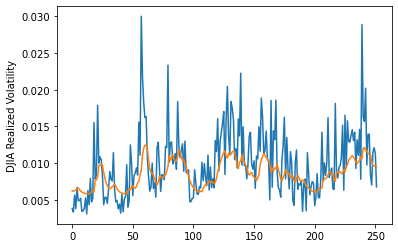

In [39]:
# Best model
plt.plot(range(252), test)
plt.plot(range(252), true_predictions) 
plt.ylabel("DJIA Realized Volatility")